In [1]:
import pickle
import numpy as np
import pandas as pd
import datetime
import os
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
os.chdir(r'C:\Users\Enrique\Desktop\Proyecto\Datasets')

df = pd.DataFrame(pickle.load(open('Dataframe pickle.pkl','rb')))

df.index = df["Unnamed: 0.1"].map(lambda x : datetime.datetime.strptime(x,"%Y-%m-%d"))
df.drop("Unnamed: 0", axis =1, inplace = True)
df.drop("Unnamed: 0.1", axis =1, inplace = True)

## PERCENTAGE CHANGE 

In [3]:
df = df['2014':] #decartamos los 2 primeros años

In [4]:
train = df["Change percentage"][:"2021-05-01"].values #dividimos train y test
test = df["Change percentage"]["2021-05-02":].values

In [5]:
scaler = MinMaxScaler(feature_range = (0, 1))
train_scaled = scaler.fit_transform(train.reshape(-1,1))
test_scaled = scaler.fit_transform(test.reshape(-1,1)) #escalamos los datos

In [6]:
train_scaled.shape

(2661, 1)

In [7]:
test_scaled.shape

(433, 1)

In [8]:
features_set_train = []
labels_train = []
for i in range(30, 2640):
    features_set_train.append(train_scaled[i-30:i, 0])
    labels_train.append(train_scaled[i, 0])
    
features_set_train, labels_train = np.array(features_set_train), np.array(labels_train)

#creamos arrays de 30 periodos para las lstm 
#prubeas: 30,60,90,120

In [9]:
features_set_train.shape

(2610, 30)

In [10]:
features_set_test = [] #ventanas enel test
labels_test = []
for i in range(30, 420):
    features_set_test.append(test_scaled[i-30:i, 0])
    labels_test.append(test_scaled[i, 0])
    
features_set_test, labels_test = np.array(features_set_test), np.array(labels_test)

In [11]:
#damos forma a los datos para la red neuronal

features_set_train = np.reshape(features_set_train, (features_set_train.shape[0], features_set_train.shape[1], 1))

In [12]:
features_set_test = np.reshape(features_set_test, (features_set_test.shape[0], features_set_test.shape[1], 1))

In [13]:
def SMAPE(forecast, actual): #funcon para calcular el error porcentual
    """Returns the Symmetric Mean Absolute Percentage Error between two Series"""
    masked_arr = ~((forecast==0)&(actual==0))
    diff = abs(forecast[masked_arr] - actual[masked_arr])
    avg = (abs(forecast[masked_arr]) + abs(actual[masked_arr]))/2
    print('SMAPE Error Score: ' + str(round(sum(diff/avg)/len(forecast) * 100, 2)) + ' %')
    return sum(diff/avg)/len(forecast) * 100
#

In [14]:
features_set_train.shape

(2610, 30, 1)

In [15]:
features_set_train[:][1:].shape

(2609, 30, 1)

In [16]:
model = Sequential() #creamos la estructura de la red neuronal
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set_train.shape[1], 1)))

# =============================================================================
# units son las neuronas a añadir
# return_sequences (True) es para añadir más capas a la red
# En input shape el primer parametro es el número de pasos de tiempo 
# y el segundo el número de variables
# =============================================================================

model.add(Dropout(0.2))

# para controlar el overfitting (muy tipico en NN)

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Añadimos más capas y por último para hacerlo más robusto una capa densa.
# el número de unidades está fijado en 1 porque queremos predecir un único valor: stock

model.add(Dense(units=1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# podemos usar como función el error cuadrático medio o el SMAPE definido

model.fit(features_set_train, labels_train, epochs = 50, batch_size = 32)
# Rule of Thumb 100 etapas y tamaño del batch a 32


Epoch 1/50
82/82 [==============================] - 17s 56ms/step - loss: 0.0212
Epoch 2/50
82/82 [==============================] - 6s 72ms/step - loss: 0.0076
Epoch 3/50
82/82 [==============================] - 5s 66ms/step - loss: 0.0070
Epoch 4/50
82/82 [==============================] - 6s 69ms/step - loss: 0.0071
Epoch 5/50
82/82 [==============================] - 5s 66ms/step - loss: 0.0069
Epoch 6/50
82/82 [==============================] - 6s 75ms/step - loss: 0.0070
Epoch 7/50
82/82 [==============================] - 5s 64ms/step - loss: 0.0069
Epoch 8/50
82/82 [==============================] - 6s 77ms/step - loss: 0.0067
Epoch 9/50
82/82 [==============================] - 6s 76ms/step - loss: 0.0067
Epoch 10/50
82/82 [==============================] - 6s 73ms/step - loss: 0.0065
Epoch 11/50
82/82 [==============================] - 6s 68ms/step - loss: 0.0063
Epoch 12/50
82/82 [==============================] - 5s 60ms/step - loss: 0.0062
Epoch 13/50
82/82 [=================

In [17]:
yhat = model.predict(features_set_test)
yhat = scaler.inverse_transform(yhat)
ytrue = scaler.inverse_transform(labels_test.reshape(-1, 1))
SMAPE(ytrue,yhat)

13/13 [==============================] - 4s 25ms/step
SMAPE Error Score: 167.86 %


167.86254311121087

In [19]:
from sklearn import metrics
sklearn.metrics.r2_score(ytrue,yhat)

-0.008656511804204348

## LSTM  PRECIO

In [20]:
train = df["Close"][:"2021-12-31"].values
test = df["Close"]["2021-12-31":].values

In [21]:
train.shape

(2905,)

In [22]:
scaler1 = MinMaxScaler(feature_range = (0, 1))
train_scaled = scaler1.fit_transform(train.reshape(-1,1))
test_scaled = scaler1.fit_transform(test.reshape(-1,1))

In [23]:
train_scaled.shape

(2905, 1)

In [24]:
test_scaled.shape

(190, 1)

In [25]:
features_set_train = []
labels_train = []
for i in range(60, 2880):
    features_set_train.append(train_scaled[i-60:i, 0])
    labels_train.append(train_scaled[i, 0])
    
features_set_train, labels_train = np.array(features_set_train), np.array(labels_train)

features_set_test = []
labels_test = []
for i in range(60, 180):
    features_set_test.append(test_scaled[i-60:i, 0])
    labels_test.append(test_scaled[i, 0])
    
features_set_test, labels_test = np.array(features_set_test), np.array(labels_test)

In [26]:
features_set_train = np.reshape(features_set_train, (features_set_train.shape[0], features_set_train.shape[1], 1))
features_set_test = np.reshape(features_set_test,(features_set_test.shape[0], features_set_test.shape[1], 1))

In [27]:
features_set_train.shape

(2820, 60, 1)

In [28]:
features_set_test.shape

(120, 60, 1)

In [29]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))


model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))


model.add(Dense(units=1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# podemos usar como función el error cuadrático medio o el SMAPE definido

model.fit(features_set_train, labels_train, epochs = 50, batch_size = 32)
# Rule of Thumb 100 etapas y tamaño del batch a 32


Epoch 1/50
89/89 [==============================] - 39s 164ms/step - loss: 0.0065
Epoch 2/50
89/89 [==============================] - 16s 177ms/step - loss: 0.0027
Epoch 3/50
89/89 [==============================] - 15s 169ms/step - loss: 0.0020
Epoch 4/50
89/89 [==============================] - 15s 165ms/step - loss: 0.0017
Epoch 5/50
89/89 [==============================] - 14s 163ms/step - loss: 0.0016
Epoch 6/50
89/89 [==============================] - 15s 172ms/step - loss: 0.0014
Epoch 7/50
89/89 [==============================] - 16s 184ms/step - loss: 0.0016
Epoch 8/50
89/89 [==============================] - 18s 199ms/step - loss: 0.0017
Epoch 9/50
89/89 [==============================] - 19s 217ms/step - loss: 0.0016
Epoch 10/50
89/89 [==============================] - 16s 178ms/step - loss: 0.0014
Epoch 11/50
89/89 [==============================] - 14s 162ms/step - loss: 0.0012
Epoch 12/50
89/89 [==============================] - 15s 165ms/step - loss: 0.0012
Epoch 13/50
8

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

In [30]:
yhat = model.predict(features_set_test)

4/4 [==============================] - 4s 39ms/step


In [31]:
yhat = scaler1.inverse_transform(yhat)
ytrue = scaler1.inverse_transform(labels_test.reshape(-1, 1))

In [32]:
from sklearn import metrics


sklearn.metrics.r2_score(ytrue,yhat)

0.941309572001945

In [33]:
SMAPE(ytrue,yhat)

SMAPE Error Score: 4.38 %


4.384056993448017

In [34]:
sklearn.metrics.mean_squared_error(ytrue,yhat, squared = False)

1921.0691124774999

In [35]:
pred = pd.DataFrame(ytrue, columns = ["ytrue"]) #DF CON PREDICCION Y REAL PARA VER EL ERROR
pred["yhat"] = yhat
pred["err"] = abs(ytrue -yhat)


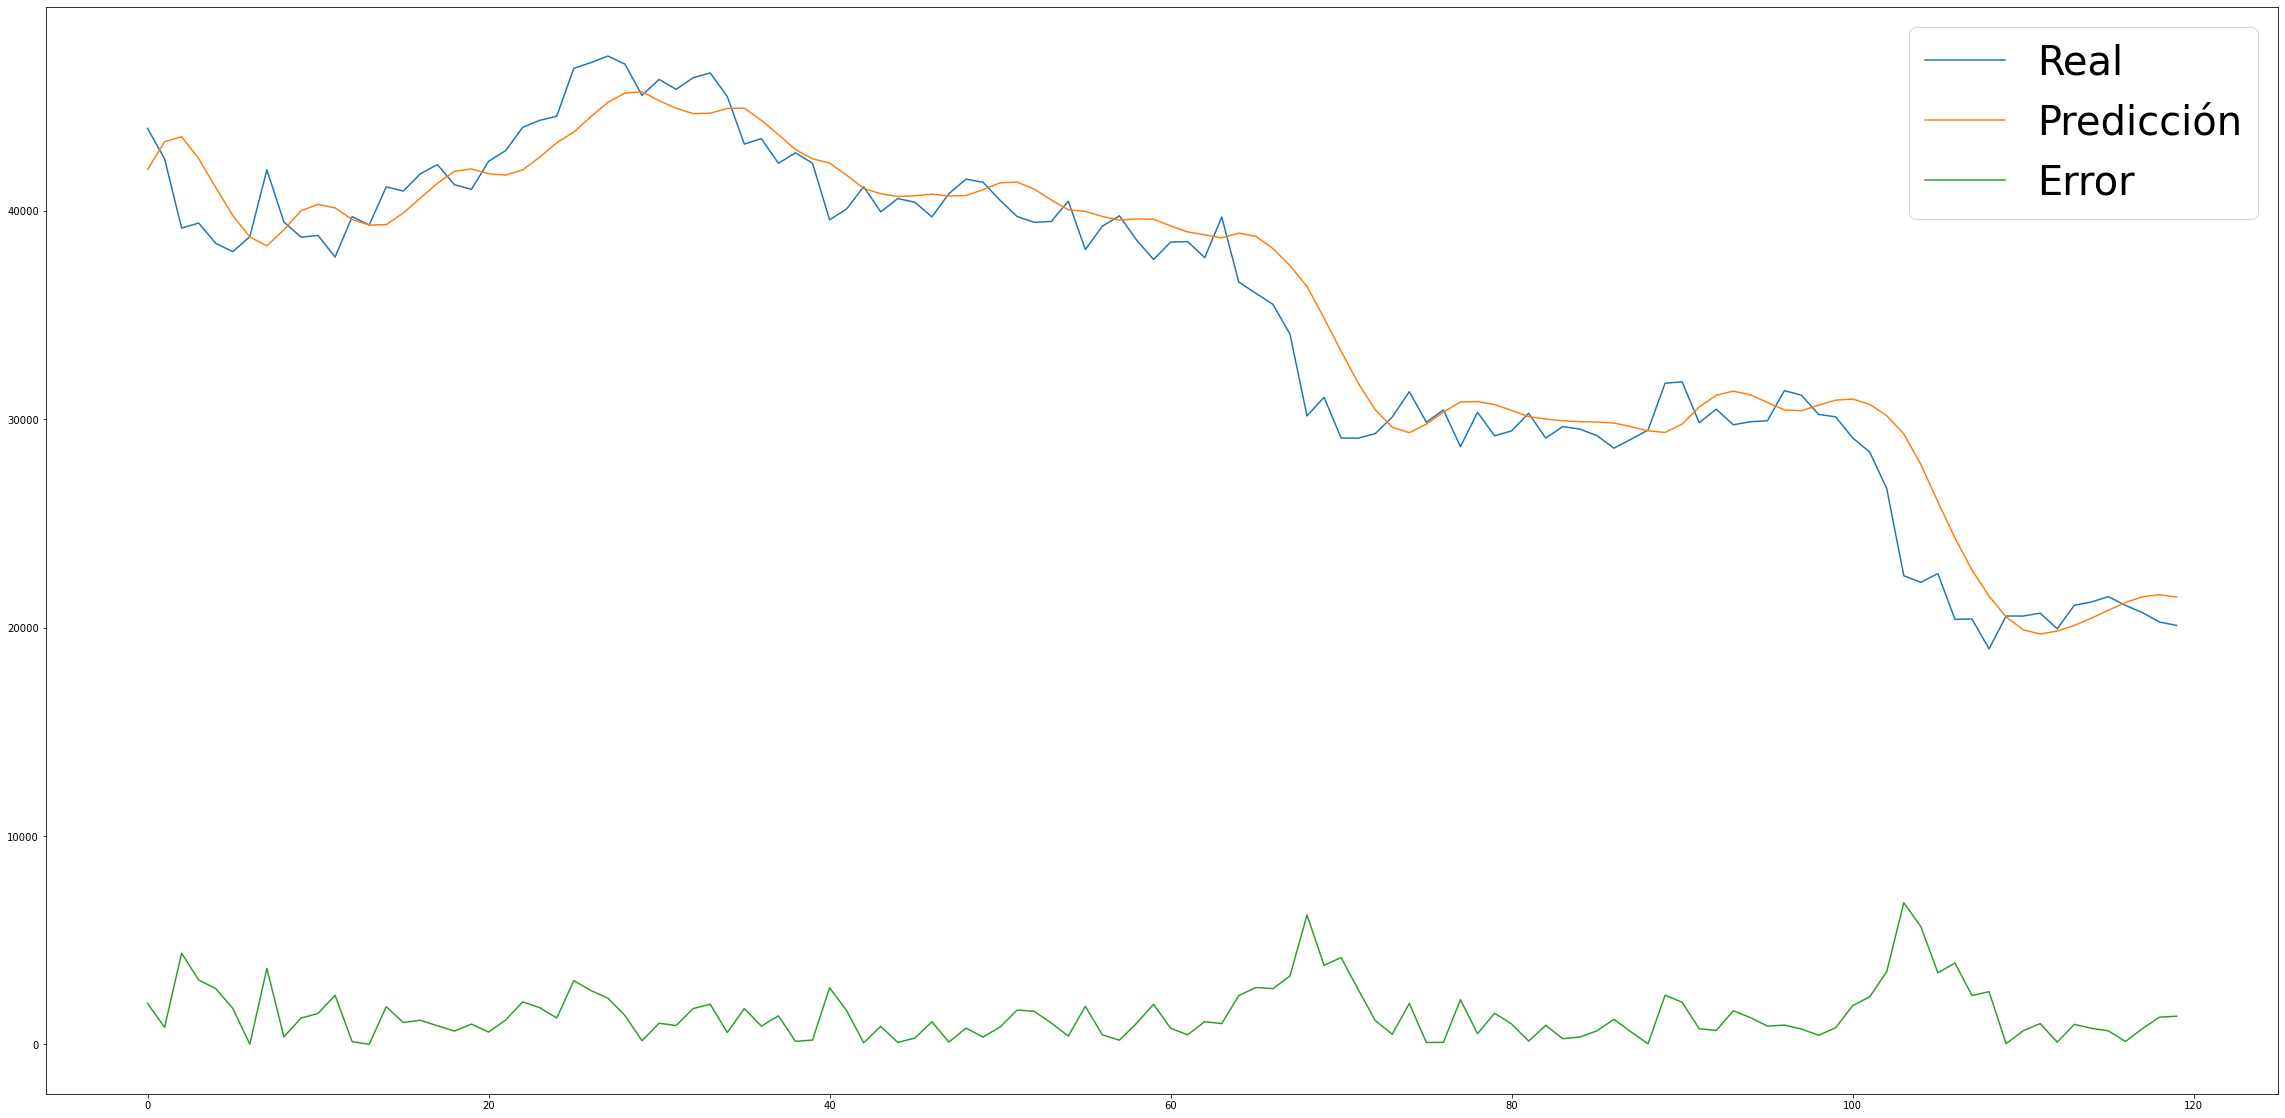

In [36]:
figure,ax = plt.subplots(figsize=(40,20))
ax.plot(pred["ytrue"], label="Real")  
ax.plot(pred["yhat"], label="Predicción")  
ax.plot(pred["err"], label="Error")
ax.legend(loc=1,prop={'size': 40} ) 
plt.show()

In [39]:
aciertos = []
aciertos.append(np.nan)

for i in range(1,len(pred)):
    if pred["ytrue"][i] > pred["ytrue"][i-1] and pred["yhat"][i] > pred["yhat"][i-1]:
        aciertos.append("Acierta")
    elif pred["ytrue"][i] < pred["ytrue"][i-1] and pred["yhat"][i] < pred["yhat"][i-1]:
        aciertos.append("Acierta")
    else:
        aciertos.append("Falla")

In [40]:
cambio = []
cambio.append(np.nan)

for i in range(1,len(pred)):
    if pred["ytrue"][i] > pred["ytrue"][i-1]:
        cambio.append("Sube")
    else:
        cambio.append("Baja")
        

In [41]:
pred_cambio = []
pred_cambio.append(np.nan)

for i in range(1,len(pred)):
    if pred["yhat"][i] > pred["yhat"][i-1]:
        pred_cambio.append("Sube")
    else:
        pred_cambio.append("Baja")

In [42]:
pred["Aciertos"] = aciertos
pred["Cambio"] = cambio
pred["Pred_cambio"] = pred_cambio 
pred["Close"] = df["Close"][-130:-10].values
pred["Open"] = df["Open"][-130:-10].values
pred["High"] = df["High"][-130:-10].values
pred["Low"] = df["Low"][-130:-10].values

In [43]:
pred.head(5)

,ytrue,yhat,err,Aciertos,Cambio,Pred_cambio,Close,Open,High,Low
0,43952.00000,41975.007812,1976.992188,NaN,NaN,NaN,43952.00000,44442.0,45326.00000,43386.0
1,42490.00000,43311.554688,821.554688,Falla,Baja,Sube,42490.00000,43952.0,44103.00000,41862.0
2,39171.00000,43552.285156,4381.285156,Falla,Baja,Sube,39171.00000,42489.0,42559.00781,38621.0
3,39408.00000,42501.699219,3093.699219,Falla,Sube,Baja,39408.00000,39171.0,39628.00000,38680.0
4,38437.04688,41115.746094,2678.699214,Acierta,Baja,Baja,38437.04688,39408.0,39715.00000,38151.0


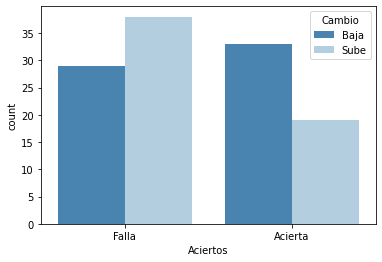

In [44]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="Aciertos", hue="Cambio", data=pred, palette="Blues_r") # nombre de la palette
plt.show()

#plot de aciertos y fallos en cambios negativos y positivos

In [45]:
pred["Aciertos"].value_counts(normalize = True)

Falla      0.563025
Acierta    0.436975
Name: Aciertos, dtype: float64

## LSTM  PRECIO DE CIERRE CON VARIABLES CON MAYOR IMPORTANIA EN MODELOS
## ANTERIORES

In [ ]:
train = df["Close"][:"2021-12-31"].values
test = df["Close"]["2021-12-31":].values

In [6]:
scaler1 = MinMaxScaler(feature_range = (0, 1))
train_scaled = scaler1.fit_transform(train.reshape(-1,1))
test_scaled = scaler1.fit_transform(test.reshape(-1,1))

In [7]:
features_set_train = []
labels_train = []
for i in range(60, 2880):
    features_set_train.append(train_scaled[i-60:i, 0])
    labels_train.append(train_scaled[i, 0])
    
features_set_train, labels_train = np.array(features_set_train), np.array(labels_train)

dftrain = pd.DataFrame(features_set_train)
scaler2 = MinMaxScaler(feature_range = (0, 1))
dftrain['Kst_signal'] = scaler2.fit_transform(df['Kst_signal'][:"2021-12-31"][60:2880].values.reshape(-1,1))
scaler7 = MinMaxScaler(feature_range = (0, 1))
dftrain['miner.sply'] = scaler7.fit_transform(df['miner.sply'][:"2021-12-31"][60:2880].values.reshape(-1,1))
scaler9 = MinMaxScaler(feature_range = (0, 1))
dftrain['TEMA 9'] = scaler9.fit_transform(df['TEMA 9'][:"2021-12-31"][60:2880].values.reshape(-1,1))
scaler10 = MinMaxScaler(feature_range = (0, 1))
dftrain['Heikin closes'] = scaler10.fit_transform(df['Heikin closes'][:"2021-12-31"][60:2880].values.reshape(-1,1))
scaler11 = MinMaxScaler(feature_range = (0, 1))
dftrain['Heikin highs'] = scaler11.fit_transform(df['Heikin highs'][:"2021-12-31"][60:2880].values.reshape(-1,1))


features_set_test = []
labels_test = []
for i in range(60, 180):
    features_set_test.append(test_scaled[i-60:i, 0])
    labels_test.append(test_scaled[i, 0])
    
features_set_test, labels_test = np.array(features_set_test), np.array(labels_test)

dftest = pd.DataFrame(features_set_test)

dftest['Kst_signal_1'] = scaler2.fit_transform(df['Kst_signal_1']["2021-12-31":][60:180].values.reshape(-1,1))
dftest['miner.sply_1'] = scaler7.fit_transform(df['miner.sply_1']["2021-12-31":][60:180].values.reshape(-1,1)) 
dftest['TEMA 9_1'] = scaler9.fit_transform(df['TEMA 9_1']["2021-12-31":][60:180].values.reshape(-1,1)) 
dftest['Heikin closes_1'] = scaler10.fit_transform(df['Heikin closes_1']["2021-12-31":][60:180].values.reshape(-1,1))
dftest['Heikin highs_1'] = scaler10.fit_transform(df['Heikin highs_1']["2021-12-31":][60:180].values.reshape(-1,1)) 

In [8]:
features_set_train = np.reshape(np.array(dftrain), (dftrain.shape[0], dftrain.shape[1], 1))
features_set_test = np.reshape(np.array(dftest), (dftest.shape[0], dftrain.shape[1], 1))

In [9]:
features_set_train.shape

(2820, 65, 1)

In [10]:
features_set_test.shape

(120, 65, 1)

In [11]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set_train.shape[1], 1)))

# =============================================================================
# units son las neuronas a añadir
# return_sequences (True) es para añadir más capas a la red
# En input shape el primer parametro es el número de pasos de tiempo 
# y el segundo el número de variables
# =============================================================================

model.add(Dropout(0.2))

# para controlar el overfitting (muy tipico en NN)

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))

model.add(LSTM(units=120, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))


# Añadimos más capas y por último para hacerlo más robusto una capa densa.
# el número de unidades está fijado en 1 porque queremos predecir un único valor: stock

model.add(Dense(units=1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])
# podemos usar como función el error cuadrático medio o el SMAPE definido

model.fit(features_set_train, labels_train, epochs = 50, batch_size = 32)
# Rule of Thumb 100 etapas y tamaño del batch a 32


Epoch 1/50
89/89 [==============================] - 23s 147ms/step - loss: 3.0669e-04 - mean_squared_error: 3.0669e-04
Epoch 2/50
89/89 [==============================] - 14s 161ms/step - loss: 8.9310e-05 - mean_squared_error: 8.9310e-05
Epoch 3/50
89/89 [==============================] - 14s 162ms/step - loss: 5.7028e-05 - mean_squared_error: 5.7028e-05
Epoch 4/50
89/89 [==============================] - 15s 165ms/step - loss: 3.8958e-05 - mean_squared_error: 3.8958e-05
Epoch 5/50
89/89 [==============================] - 14s 160ms/step - loss: 3.6007e-05 - mean_squared_error: 3.6007e-05
Epoch 6/50
89/89 [==============================] - 14s 161ms/step - loss: 3.5570e-05 - mean_squared_error: 3.5570e-05
Epoch 7/50
89/89 [==============================] - 14s 160ms/step - loss: 4.0143e-05 - mean_squared_error: 4.0143e-05
Epoch 8/50
89/89 [==============================] - 15s 165ms/step - loss: 3.3875e-05 - mean_squared_error: 3.3875e-05
Epoch 9/50
89/89 [==============================

In [12]:
yhat = model.predict(features_set_test)
yhat = scaler1.inverse_transform(yhat)
ytrue = scaler1.inverse_transform(labels_test.reshape(-1, 1))

4/4 [==============================] - 3s 43ms/step


In [13]:
from sklearn import metrics
sklearn.metrics.r2_score(ytrue,yhat)

-1.3269706733241753

In [17]:
SMAPE(ytrue,yhat)

SMAPE Error Score: 33.22 %


33.217396421747516

In [18]:
pred2 = pd.DataFrame(ytrue, columns = ["ytrue"])
pred2["yhat"] = yhat
pred2["err"] = abs(ytrue -yhat)


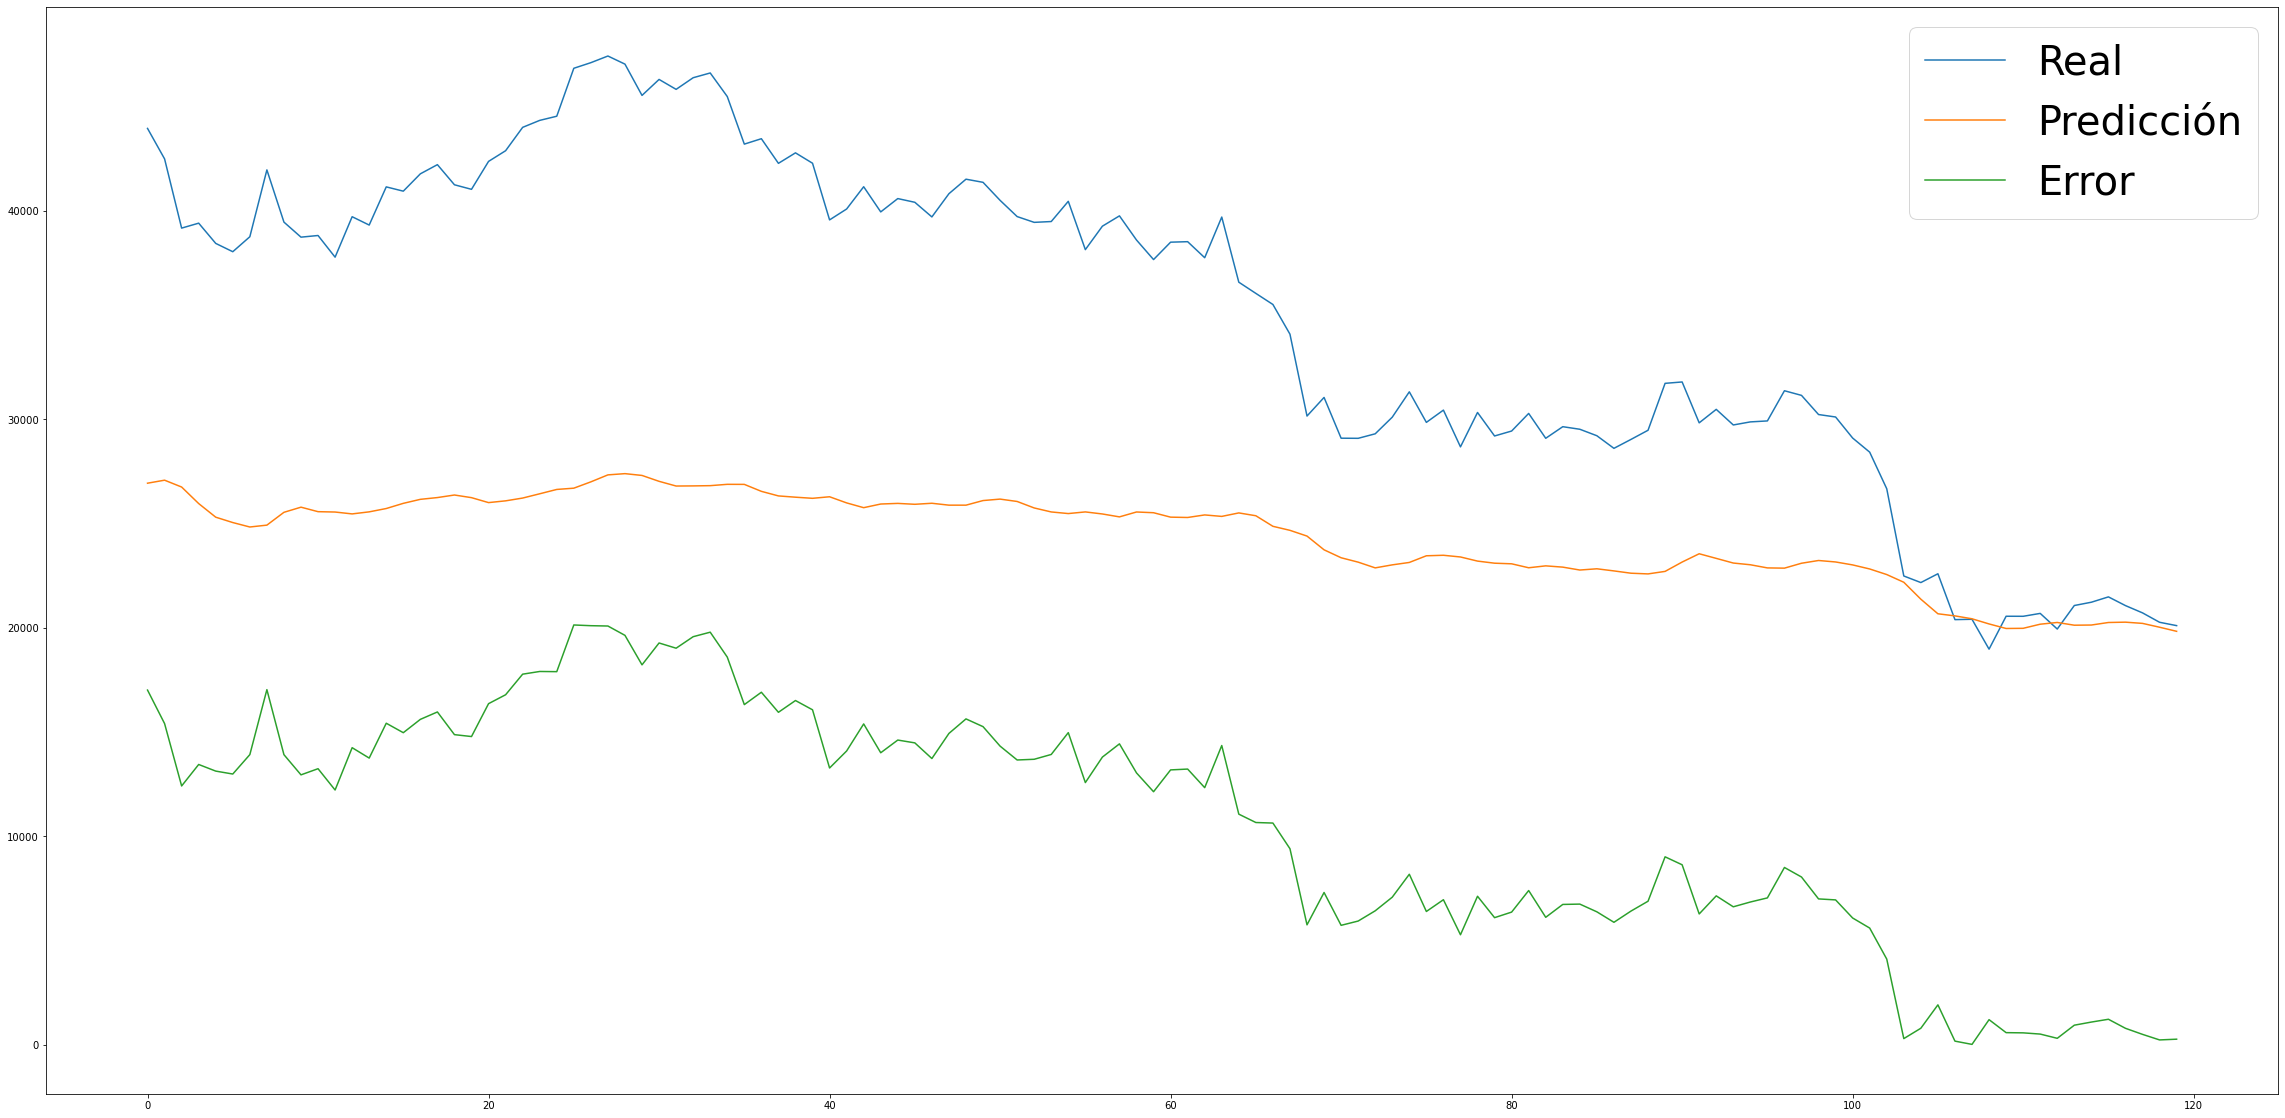

In [19]:
figure,ax = plt.subplots(figsize=(40,20))
ax.plot(pred2["ytrue"], label="Real")  
ax.plot(pred2["yhat"], label="Predicción")  
ax.plot(pred2["err"], label="Error")
ax.legend(loc=1,prop={'size': 40} ) 
plt.show()

In [157]:
aciertos = []
aciertos.append(np.nan)

for i in range(1,len(pred2)):
    if pred2["ytrue"][i] > pred2["ytrue"][i-1] and pred2["yhat"][i] > pred2["yhat"][i-1]:
        aciertos.append(1)
    elif pred2["ytrue"][i] < pred2["ytrue"][i-1] and pred2["yhat"][i] < pred2["yhat"][i-1]:
        aciertos.append(1)
    else:
        aciertos.append(0)
        
        

In [158]:
pred["Sube_baja"] = aciertos
pred["Sube_baja"].value_counts(normalize = True)

0.0    0.529248
1.0    0.470752
Name: Sube_baja, dtype: float64

In [275]:
pred

,ytrue,yhat,err,Sube_baja
0,86.784585,77.986511,8.798074,NaN
1,81.704139,82.680954,0.976815,0.0
2,70.170622,83.036484,12.865861,0.0
3,70.994197,78.753281,7.759084,0.0
4,67.620137,73.841919,6.221782,1.0
...,...,...,...,...
115,8.711818,7.125294,1.586524,1.0
116,7.259270,8.318663,1.059393,0.0
117,6.046495,9.111597,3.065102,0.0
118,4.479272,9.257090,4.777818,0.0


# STRATEGY BACKTEST

In [188]:
pred.head(5)

,ytrue,yhat,err,Aciertos,Cambio,Pred_cambio,Close,Open,High,Low
0,43952.00000,41759.500000,2192.500000,NaN,NaN,NaN,43952.00000,44442.0,45326.00000,43386.0
1,42490.00000,43035.480469,545.480469,Falla,Baja,Sube,42490.00000,43952.0,44103.00000,41862.0
2,39171.00000,43041.000000,3870.000000,Falla,Baja,Sube,39171.00000,42489.0,42559.00781,38621.0
3,39408.00000,41687.441406,2279.441406,Falla,Sube,Baja,39408.00000,39171.0,39628.00000,38680.0
4,38437.04688,40171.789062,1734.742182,Acierta,Baja,Baja,38437.04688,39408.0,39715.00000,38151.0


In [189]:
pred["%"] =  pred["ytrue"].pct_change()

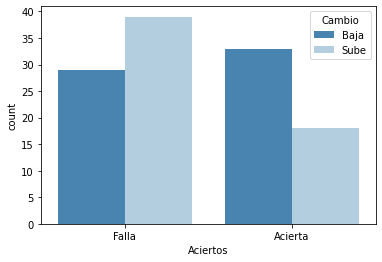

In [108]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="Aciertos", hue="Cambio", data=pred, palette="Blues_r") # nombre de la palette
plt.show()

In [46]:
from backtesting import Backtest, Strategy
from backtesting.lib import SignalStrategy, TrailingStrategy


class strat(Strategy): #clase heredando luna clase de la biblioteca de backtesting
    
    def init(self):
        self.order = None
        price = self.data["Close"]
        long_sl = price * 0.99 # definimo stop loss
        short_sl = price * 1.01 # definimo take profit
        
      
    def next(self): #strategia de compra cuan el modelo predice que el precio es mayor al día anterior y venta cuando es menor
        price = self.data["Close"]
        
        for i in pred["Pred_cambio"]:
            if i == "Baja":
                    self.order = self.sell()
            elif i == "Sube":
                    self.order = self.buy()

bt = Backtest(pred, strat,
              exclusive_orders=True, cash = 100000)
stats = bt.run()
bt.plot()

C:\Users\Enrique\anaconda3\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

C:\Users\Enrique\AppData\Local\Temp/ipykernel_48308/3637103397.py:23: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(pred, strat,


Row(id='1332', ...)

In [47]:
stats #estadisticas del bakstesting de la estrategia

Start                                     0.0
End                                     119.0
Duration                                119.0
Exposure Time [%]                   98.333333
Equity Final [$]                 171632.28714
Equity Peak [$]                  182591.70898
Return [%]                          71.632287
Buy & Hold Return [%]              -54.253384
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -17.094822
Avg. Drawdown [%]                   -6.246294
Max. Drawdown Duration                   53.0
Avg. Drawdown Duration                   10.9
# Trades                                118.0
Win Rate [%]                        50.847458
Best Trade [%]                      15.635546
Worst Trade [%]                     -8.314891
Avg. Trade [%]                    

# PRUEBA SP500

In [86]:
os.chdir(r'C:\Users\Enrique\Desktop\Proyecto\Datasets')

df500 = pd.read_csv('Indices bursátiles.csv')
df500.index = df500["datetime"]
df500.drop("datetime", axis =1, inplace = True)

In [100]:
df500.head(5)

,open_sp,high_sp,low_sp,close_sp,open_nq,high_nq,low_nq,close_nq,open_dxy,high_dxy,low_dxy,close_dxy
datetime,,,,,,,,,,,,
2012-01-31,1313.53003,1321.41003,1306.68994,1312.41003,2825.76001,2830.44995,2798.77002,2813.84009,79.10,79.48,78.74,79.28
2012-02-01,1312.44995,1330.52002,1312.44995,1324.08997,2830.10010,2855.72998,2825.18994,2848.27002,79.31,79.57,78.62,78.92
2012-02-02,1324.23999,1329.18994,1321.56995,1325.54004,2854.10010,2868.22998,2849.39990,2859.67993,78.84,79.20,78.71,78.97
2012-02-03,1326.20996,1345.33997,1326.20996,1344.90002,2888.94995,2908.12988,2885.84009,2905.65991,79.01,79.36,78.75,78.94
2012-02-06,1344.31995,1344.35999,1337.52002,1344.32996,2892.52002,2903.03003,2887.33008,2901.98999,79.07,79.52,78.98,79.09


In [110]:
train = df500["close_sp"][:"2021-10-20"].values
test = df500["close_sp"]["2021-10-20":].values

In [111]:
scaler1 = MinMaxScaler(feature_range = (0, 1))
train_scaled = scaler1.fit_transform(train.reshape(-1,1))
test_scaled = scaler1.fit_transform(test.reshape(-1,1))

In [112]:
train_scaled.shape

(2622, 1)

In [113]:
test_scaled.shape

(180, 1)

In [115]:
features_set_train = []
labels_train = []
for i in range(60, 2580):
    features_set_train.append(train_scaled[i-60:i, 0])
    labels_train.append(train_scaled[i, 0])
    
features_set_train, labels_train = np.array(features_set_train), np.array(labels_train)

features_set_test = []
labels_test = []
for i in range(60, 180):
    features_set_test.append(test_scaled[i-60:i, 0])
    labels_test.append(test_scaled[i, 0])
    
features_set_test, labels_test = np.array(features_set_test), np.array(labels_test)

In [116]:
features_set_train = np.reshape(features_set_train, (features_set_train.shape[0], features_set_train.shape[1], 1))
features_set_test = np.reshape(features_set_test,(features_set_test.shape[0], features_set_test.shape[1], 1))

In [118]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))


model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))


model.add(Dense(units=1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# podemos usar como función el error cuadrático medio o el SMAPE definido

model.fit(features_set_train, labels_train, epochs = 100, batch_size = 32)
# Rule of Thumb 100 etapas y tamaño del batch a 32

Epoch 1/100
79/79 [==============================] - 24s 106ms/step - loss: 0.0131
Epoch 2/100
79/79 [==============================] - 8s 107ms/step - loss: 0.0028
Epoch 3/100
79/79 [==============================] - 9s 114ms/step - loss: 0.0023
Epoch 4/100
79/79 [==============================] - 10s 130ms/step - loss: 0.0022
Epoch 5/100
79/79 [==============================] - 11s 143ms/step - loss: 0.0019
Epoch 6/100
79/79 [==============================] - 12s 150ms/step - loss: 0.0022
Epoch 7/100
79/79 [==============================] - 12s 149ms/step - loss: 0.0020
Epoch 8/100
79/79 [==============================] - 12s 157ms/step - loss: 0.0018
Epoch 9/100
79/79 [==============================] - 13s 165ms/step - loss: 0.0016
Epoch 10/100
79/79 [==============================] - 12s 154ms/step - loss: 0.0017
Epoch 11/100
79/79 [==============================] - 12s 153ms/step - loss: 0.0017
Epoch 12/100
79/79 [==============================] - 13s 159ms/step - loss: 0.0015
Epo

In [119]:
yhat = model.predict(features_set_test)

4/4 [==============================] - 4s 54ms/step


In [120]:
yhat = scaler1.inverse_transform(yhat)
ytrue = scaler1.inverse_transform(labels_test.reshape(-1, 1))

In [121]:
from sklearn import metrics
sklearn.metrics.r2_score(ytrue,yhat)

0.8483445250353122

In [122]:
def SMAPE(forecast, actual):
    """Returns the Symmetric Mean Absolute Percentage Error between two Series"""
    masked_arr = ~((forecast==0)&(actual==0))
    diff = abs(forecast[masked_arr] - actual[masked_arr])
    avg = (abs(forecast[masked_arr]) + abs(actual[masked_arr]))/2
    print('SMAPE Error Score: ' + str(round(sum(diff/avg)/len(forecast) * 100, 2)) + ' %')
    return sum(diff/avg)/len(forecast) * 100

In [123]:
SMAPE(ytrue,yhat)

SMAPE Error Score: 1.95 %


1.9531827582784298

In [124]:
sklearn.metrics.mean_squared_error(ytrue,yhat, squared = False)

101.3002236240141

In [125]:
pred = pd.DataFrame(ytrue, columns = ["ytrue"])
pred["yhat"] = yhat
pred["err"] = abs(ytrue -yhat)

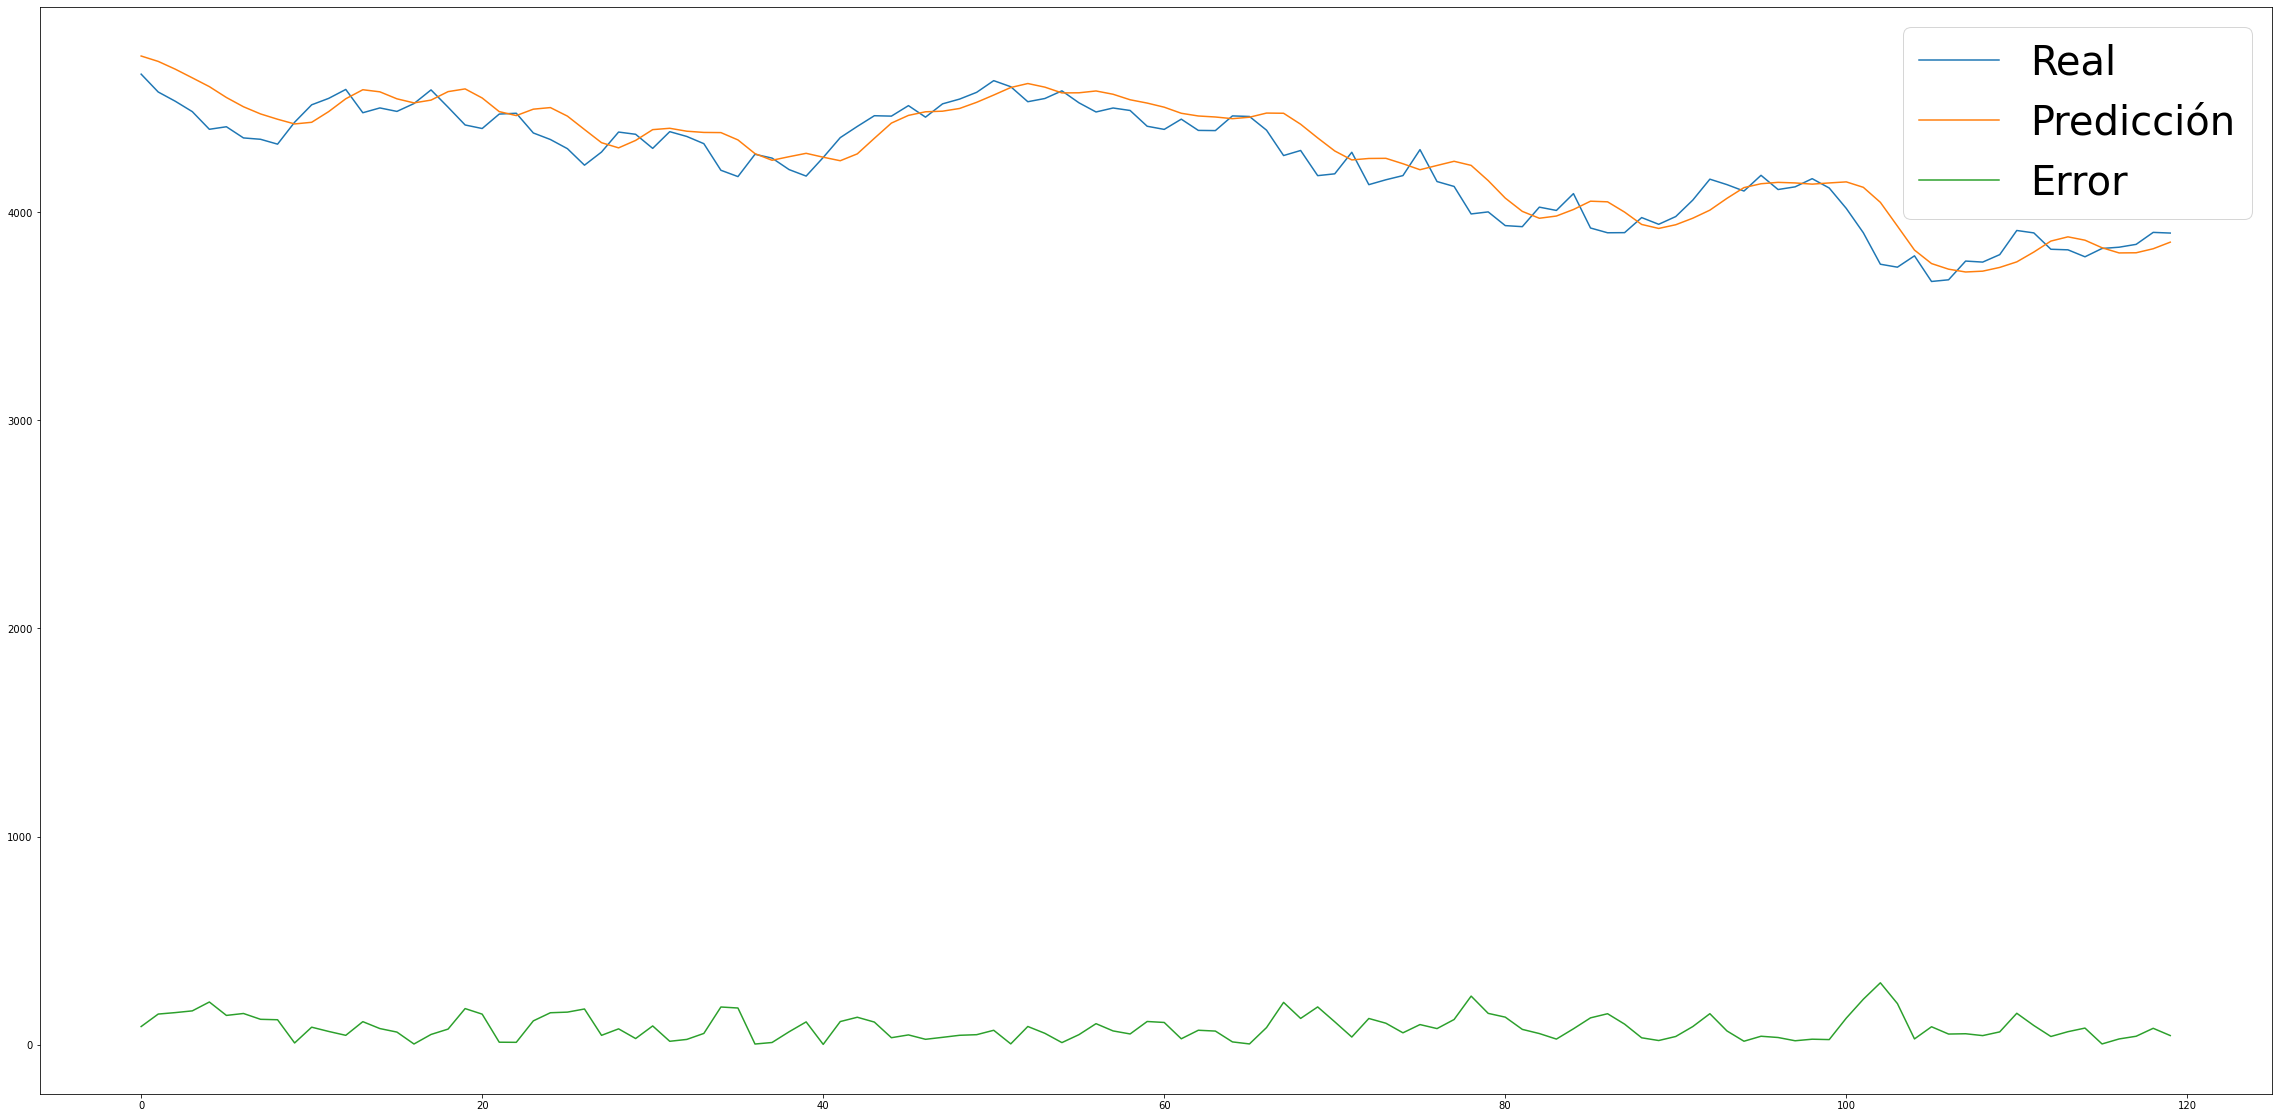

In [126]:
figure,ax = plt.subplots(figsize=(40,20))
ax.plot(pred["ytrue"], label="Real")  
ax.plot(pred["yhat"], label="Predicción")  
ax.plot(pred["err"], label="Error")
ax.legend(loc=1,prop={'size': 40} ) 
plt.show()

In [128]:
aciertos = []
aciertos.append(np.nan)

for i in range(1,len(pred)):
    if pred["ytrue"][i] > pred["ytrue"][i-1] and pred["yhat"][i] > pred["yhat"][i-1]:
        aciertos.append("Acierta")
    elif pred["ytrue"][i] < pred["ytrue"][i-1] and pred["yhat"][i] < pred["yhat"][i-1]:
        aciertos.append("Acierta")
    else:
        aciertos.append("Falla")

In [129]:
cambio = []
cambio.append(np.nan)

for i in range(1,len(pred)):
    if pred["ytrue"][i] > pred["ytrue"][i-1]:
        cambio.append("Sube")
    else:
        cambio.append("Baja")

In [130]:
pred_cambio = []
pred_cambio.append(np.nan)

for i in range(1,len(pred)):
    if pred["yhat"][i] > pred["yhat"][i-1]:
        pred_cambio.append("Sube")
    else:
        pred_cambio.append("Baja")

In [136]:
pred["Aciertos"] = aciertos
pred["Cambio"] = cambio
pred["Pred_cambio"] = pred_cambio 
pred["Close"] = df500["close_sp"][-130:-10].values
pred["Open"] = df500["open_sp"][-130:-10].values
pred["High"] = df500["high_sp"][-130:-10].values
pred["Low"] = df500["low_sp"][-130:-10].values

In [137]:
pred.head(5)

,ytrue,yhat,err,Aciertos,Cambio,Pred_cambio,Close,Open,High,Low
0,4662.85010,4749.967773,87.117673,NaN,NaN,NaN,4766.18018,4775.20996,4786.83008,4765.75000
1,4577.10986,4724.125488,147.015628,Acierta,Baja,Baja,4796.56006,4778.14014,4796.64014,4758.16992
2,4532.75977,4686.799805,154.040035,Acierta,Baja,Baja,4793.54004,4804.50977,4818.62012,4774.27002
3,4482.72998,4645.107422,162.377442,Acierta,Baja,Baja,4700.58008,4787.99023,4797.70020,4699.43994
4,4397.93994,4602.910645,204.970705,Acierta,Baja,Baja,4696.04980,4693.39014,4725.00977,4671.25977


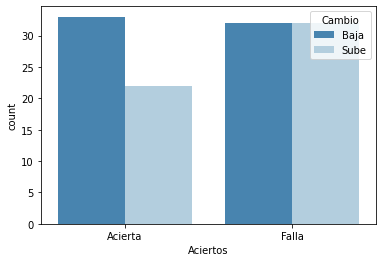

In [138]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="Aciertos", hue="Cambio", data=pred, palette="Blues_r") # nombre de la palette
plt.show()

In [139]:
pred["Aciertos"].value_counts(normalize = True)

Falla      0.537815
Acierta    0.462185
Name: Aciertos, dtype: float64

In [142]:
from backtesting import Backtest, Strategy
from backtesting.lib import SignalStrategy, TrailingStrategy


class strat(Strategy):
    
    def init(self):
        self.order = None
        price = self.data["Close"]
        long_sl = price * 0.99
        short_sl = price * 1.01
        
      
    def next(self):
        price = self.data["Close"]
        
        for i in pred["Pred_cambio"]:
            if i == "Baja":
                    self.order = self.sell()
            elif i == "Sube":
                    self.order = self.buy()

bt = Backtest(pred, strat,
              exclusive_orders=True, cash = 10000)
stats = bt.run()
bt.plot()

C:\Users\Enrique\AppData\Local\Temp/ipykernel_48160/4176926674.py:23: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(pred, strat,


Row(id='3596', ...)

In [143]:
stats

Start                                     0.0
End                                     119.0
Duration                                119.0
Exposure Time [%]                   98.333333
Equity Final [$]                   7982.44042
Equity Peak [$]                       10000.0
Return [%]                         -20.175596
Buy & Hold Return [%]              -20.361173
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -22.754795
Avg. Drawdown [%]                  -22.754795
Max. Drawdown Duration                  118.0
Avg. Drawdown Duration                  118.0
# Trades                                118.0
Win Rate [%]                             50.0
Best Trade [%]                       3.431611
Worst Trade [%]                     -3.911281
Avg. Trade [%]                    